<a href="https://colab.research.google.com/github/cedjustin/AI/blob/master/sprint12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing dependencies
import numpy as np
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
# preparation of the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[0:30000,:]
y_train = y_train[0:30000]
X_test = X_test[0:30000,:]
y_test = y_test[0:30000]

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)


X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) 
print(y_train_one_hot.shape) 
print(y_train_one_hot.dtype) 

11493376/11490434 [==============================] - 0s 0us/step
(30000,)
(30000, 10)
float64


In [3]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train--->", X_train_.shape) 
print("X_val--->", X_val.shape)  
print("y_train--->", y_train_.shape) 
print("y_val--->", y_val.shape)

X_train---> (24000, 784)
X_val---> (6000, 784)
y_train---> (24000, 10)
y_val---> (6000, 10)


In [4]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
for mini_X_train, mini_y_train in get_mini_batch:
    mini_X_train, mini_y_train
mini_X_train = mini_X_train.reshape(20, 1, 28, 28)

In [5]:
class SimpleInitializer:
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self,f_num, Chanel, f_size_h, f_size_w):
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W
    
    def B(self, f_num):
        np.random.seed(0)
        self.B = self.sigma * np.random.randn(f_num,1)
        return self.B

class XavierInitializer:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self,f_num, Chanel, f_size_h, f_size_w):
        self.sigma = (1 / np.sqrt(f_num))
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W
        
    def B(self,f_num):
        np.random.seed(0)
        self.sigma = (1 / np.sqrt(f_num))
        self.B = self.sigma * np.random.randn(f_num,1)
        return self.B

class He:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
    
    def W(self, f_num, Chanel, f_size_h, f_size_w):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.W = sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W
        
    def B(self,f_num):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.B = sigma * np.random.randn(f_num,1)
        return self.B

class SGD:

    def __init__(self, lr=0.001):
        self.lr = lr
        
    def update(self,layer):

        layer.W -= (self.lr * layer.dW)
        layer.B -= (self.lr * layer.dB)
        return layer.W, layer.B

In [6]:
def output_heigh_calculation(X_h,pad_n,F_h,stride):
    output_h = (X_h + 2*pad_n - F_h)//stride + 1
    return output_h

In [7]:
def output_width_calculation(X_w,pad_n,F_w,stride):
    output_w = (X_w + 2*pad_n - F_w)//stride + 1
    return output_w

In [8]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = output_heigh_calculation(X_h=H,pad_n=pad, F_h=filter_h, stride=stride)
    out_w = output_width_calculation(X_w=W,pad_n=pad, F_w=filter_w, stride=stride)
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [9]:
def col2im(col, X, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = X.shape
    out_h = output_heigh_calculation(X_h=H,pad_n=pad, F_h=filter_h, stride=stride)
    out_w = output_width_calculation(X_w=W,pad_n=pad, F_w=filter_w, stride=stride)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

【Problem 1】Creating a 2-D convolutional layer

In [10]:
class SimpleConv2d:
    
    def __init__(self, f_num=1, f_size_h=2, f_size_w=2, stride=1, pad = 1, initializer=XavierInitializer(), optimizer=SGD(lr=0.05)):

        self.f_num = f_num
        self.f_size_h = f_size_h
        self.f_size_w = f_size_w
        self.pad = pad
        self.stride = stride
        self.kernel  = None
        self.initializer = initializer
        self.optimizer = optimizer
        self.W = None
        self.B = None 
        
    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = output_heigh_calculation(X_h=H,pad_n=self.pad, F_h= self.f_size_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.f_size_w, stride=self.stride)
        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.f_size_h, self.f_size_w, out_h, out_w))

        for y in range(self.f_size_h):
            y_max = y + self.stride*out_h
            for x in range(self.f_size_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col
    
    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = output_heigh_calculation(X_h=H,pad_n=self.pad, F_h=self.f_size_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.f_size_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.f_size_h, self.f_size_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))
        
        for y in range(self.f_size_h):
            y_max = y + self.stride*out_h
            for x in range(self.f_size_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]
        
    def forward(self,X):
        if self.W is None:
            self.W = self.initializer.W(self.f_num, X.shape[1], self.f_size_h , self.f_size_w)
        if self.B is None:
            self.B = self.initializer.B(self.f_num)
        FN, C, FH, FW = self.W.shape
        N, C, H, W = X.shape
        out_h = output_heigh_calculation(X_h=H,pad_n=self.pad, F_h=self.f_size_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.f_size_w, stride=self.stride)
            
        self.col = self.im2col(X)
        self.col_W = self.W.reshape(FN, -1).T
        out = np.dot(self.col, self.col_W) + self.B.T
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        self.X = X
        return out
    
    def backward(self,dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        self.dB = np.sum(dout, axis=0).reshape(self.f_num,1)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        self.dx = self.col2im(dcol,self.X)
        
        return self.dx
        self = self.optimizer.update(self)

In [11]:
model_test = SimpleConv2d(f_num=3, f_size_h=3,  f_size_w=3, stride=1, pad=1, initializer=SimpleInitializer())

【Problem 2】Experiment of 2D convolvolation layer in small array

In [12]:
forward_testing = model_test.forward(mini_X_train)

In [13]:
model_test.backward(forward_testing)

array([[[[1.25967230e-03, 1.01337586e-03, 1.01337586e-03, ...,
          1.01337586e-03, 1.01337586e-03, 1.65385372e-04],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         ...,
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         [1.20249692e-03, 9.53283644e-04, 9.53283644e-04, ...,
          9.53283644e-04, 9.53283644e-04, 6.04504498e-05]]],


       [[[1.25967230e-03, 1.01337586e-03, 1.01337586e-03, ...,
          1.01337586e-03, 1.01337586e-03, 1.65385372e-04],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
      

【Problem 3】

In [14]:
model_test.backward(forward_testing).shape

(20, 1, 28, 28)

【Problem 4】Create the maximum pooling layer

In [15]:
class MaxPool2D:
    
    def __init__(self, P_h, P_w, stride=1, pad=0):
        self.P_h = P_h
        self.P_w = P_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None
        
    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = output_heigh_calculation(X_h=H,pad_n=self.pad, F_h= self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.P_h, self.P_w, out_h, out_w))

        for y in range(self.P_h):
            y_max = y + self.stride*out_h
            for x in range(self.P_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col
    
    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = output_heigh_calculation(X_h=H,pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.P_h, self.P_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))
        
        for y in range(self.P_h):
            y_max = y + self.stride*out_h
            for x in range(self.P_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]
       
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = output_heigh_calculation(X_h=H,pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        col = self.im2col(x)     
        col = col.reshape(-1, self.P_h*self.P_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)    
        p_size = self.P_h * self.P_w
        dmax = np.zeros((dout.size, p_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (p_size,))     
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x)
        return dx
        self = self.optimizer.update(self)

In [16]:
test2 = MaxPool2D( P_h=2, P_w=2, stride=2, pad=0)
testing2 = test2.forward(forward_testing)
testing2backward = test2.backward(testing2)

In [17]:
testing2.shape

(20, 3, 14, 14)

In [18]:
testing2backward.shape

(20, 3, 28, 28)

[Problem 5] (Advanced Assignment) Creating Average Pooling

In [19]:
class Flatten:

    def forward(self, x):
        N, C, H, W = x.shape
        out = x.reshape(N, -1)        
        self.x = x        
        return out
    
    def backward(self, dout):
        dx = dout.reshape(self.x.shape)      
        return dx

In [20]:
smoothing = Flatten()
smoothing_f = smoothing.forward(forward_testing)
smoothing_b = smoothing.backward(smoothing_f)
print(f'Initial---> {forward_testing.shape}')
print(f'Forward--> {smoothing_f.shape}')
print(f'Backward--> {smoothing_b.shape}')

Initial---> (20, 3, 28, 28)
Forward--> (20, 2352)
Backward--> (20, 3, 28, 28)


【Problem 6】Smoothing

In [21]:
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0
        
    def forward(self, X): 
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A
    
    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return self.dZ

class SoftmaxWithLoss:
    
    def forward(self, A): 
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
        
    def backward(self, Z, y):
        dA = Z - y
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss
    
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr 
    
    def update(self, layer):
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

class HeInitializer:

    def __init__(self, sigma):
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

class Relu:

    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

In [22]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]  
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [23]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [24]:
class MaxPool2D2:

    def __init__(self, P_h, P_w, pad=0):
        self.P_h = P_h
        self.P_w = P_w
        self.stride = P_h
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.P_h) / self.stride)
        out_w = int(1 + (W - self.P_w) / self.stride)
        col = im2col(x, self.P_h, self.P_w, self.stride, self.pad)
        col = col.reshape(-1, self.P_h*self.P_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)    
        pool_size = self.P_h * self.P_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))       
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.P_h, self.P_w, self.stride, self.pad)    
        return dx

In [25]:
class Scratch2dCNNClassifier:

    def __init__(self, FN=20, FH=7, FW=7, stride=1, pad=0, epoch=1, optimizer=AdaGrad, initializer=HeInitializer, activater=Relu, verbose=False,):
        self.verbose = verbose
        self.batch_size = 60 
        self.n_output = 10 
        self.sigma = 0.02 
        self.lr = 0.05 
        self.epoch = epoch 
        self.optimizer = optimizer 
        self.initializer = initializer 
        self.activater = activater 
        self.FN = FN 
        self.C = 1 
        self.FH = FH 
        self.FW = FW 
        self.pool_h = 2 
        self.pool_w = 2 
        self.pad = pad 
        self.stride = stride 
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = [] 
        self.loss_val = []   
        out_h, out_w = self.out_size(28, 28, self.pad, self.FH, self.FW, self.stride)
        out_h, out_w = self.out_size(out_h, out_w, 0, self.pool_h, self.pool_w, self.pool_h)
        fc_nodes = self.FN * out_h * out_w 
        optimizer = self.optimizer(self.lr)    
        w = self.sigma * np.random.randn(self.FN, self.C, self.FH, self.FW)
        b = self.sigma * np.random.randn(self.FN,)
        self.cv= SimpleConv2d(self.FN, self.FH, self.FW, self.stride, self.pad, initializer=SimpleInitializer())
        self.activation_cv = self.activater()
        self.pl = MaxPool2D2(self.pool_h, self.pool_w)
        self.fl = Flatten()
        self.FC = FC(fc_nodes, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation_fc = SoftmaxWithLoss()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                
                A1 = self.cv.forward(mini_X)
                Z1 = self.activation_cv.forward(A1)
                P1 = self.pl.forward(Z1)
                F1 = self.fl.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.activation_fc.forward(A2)

                dA2, loss = self.activation_fc.backward(Z2, mini_y) 
                dZ2 = self.FC.backward(dA2)
                dF1 = self.fl.backward(dZ2)
                dP1 = self.pl.backward(dF1)
                dA1 = self.activation_cv.backward(dP1)
                dZ1 = self.cv.backward(dA1)

            if self.verbose:
                A1 = self.cv.forward(X)
                Z1 = self.activation_cv.forward(A1)
                P1 = self.pl.forward(Z1)
                F1 = self.fl.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.activation_fc.forward(A2)  
                self.loss_train.append(self.activation_fc.backward(Z2, y)[1])
                
                if X_val is not None:
                    A1 = self.cv.forward(X_val)
                    Z1 = self.activation_cv.forward(A1)
                    P1 = self.pl.forward(Z1)
                    F1 = self.fl.forward(P1)
                    A2 = self.FC.forward(F1)
                    Z2 = self.activation_fc.forward(A2)         
                    self.loss_val.append(self.activation_fc.backward(Z2, y_val)[1])
                    
    def out_size(self, H, W, P, FH, FW, S):
        out_h = (H + 2 * P - FH) // S + 1
        out_w = (W + 2 * P - FW) // S + 1
        return out_h, out_w
    
    def predict(self, X):
        A1 = self.cv.forward(X)
        Z1 = self.activation_cv.forward(A1)
        P1 = self.pl.forward(Z1)
        F1 = self.fl.forward(P1)
        A2 = self.FC.forward(F1)
        Z2 = self.activation_fc.forward(A2)
        return np.argmax(Z2, axis=1)

In [26]:
(X_train2, y_train2), (X_test2, y_test2) = mnist.load_data()

X_train2 = X_train2[0:100,:]
y_train2 = y_train2[0:100]
X_test2 = X_test2[0:100,:]
y_test2 = y_test2[0:100]

X_train2 = X_train2.astype(np.float)
X_test2 = X_test2.astype(np.float)
X_train2 /= 255 
X_test2 /= 255

X_train2 = X_train2[:, np.newaxis, :, :] 
X_test2 = X_test2[:, np.newaxis, :, :]

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot2 = enc.fit_transform(y_train2[:, np.newaxis])
y_test_one_hot2 = enc.transform(y_val2[:, np.newaxis])

【Problem 7】Learning and Estimation

In [27]:
S2dCNN = Scratch2dCNNClassifier(FN=5, FH=7, FW=7, stride=1, pad=3, epoch =10, verbose=True)
S2dCNN.fit(X_train2, y_train_one_hot2, X_val2, y_test_one_hot2)

In [28]:
pred = S2dCNN.predict(X_val2)
accuracy_score(y_val2, pred)

0.1

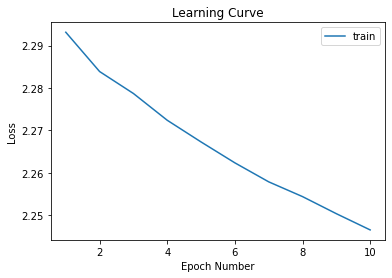

In [29]:
plt.title('Learning Curve')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(list(range(1, S2dCNN.epoch+1)), S2dCNN.loss_train, label='train')
plt.legend()

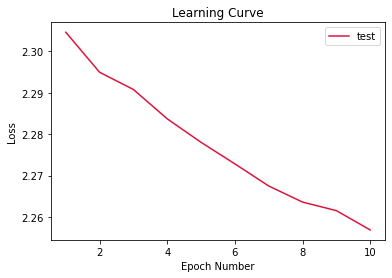

In [30]:
plt.title('Learning Curve')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(list(range(1, S2dCNN.epoch+1)), S2dCNN.loss_val, label='test', color='crimson')
plt.legend()

[Problem 9] (Advanced Task) Investigation of famous image recognition models

In [31]:
def output_size(H, W, P, FH, FW, S):
    out_h = (H + 2 * P - FH) // S + 1
    out_w = (W + 2 * P - FW) // S + 1
    return out_h, out_w

def number_of_parameters(FH, FW, C, FN):
    return FH*FW*C*FN + FN

In [32]:
test1 = output_size(144, 144, 0, 3, 3, 1)
test2 = number_of_parameters(3, 3, 3, 6)

In [33]:
test1

(142, 142)

In [34]:
test2

168

In [35]:
test3 = output_size(60, 60, 0, 3, 3, 1)
test4 = number_of_parameters(3, 3, 24, 48)

In [36]:
test3

(58, 58)

In [37]:
test4

10416

In [38]:
test5 = output_size(20, 20, 0, 3, 3, 2)
test6 = number_of_parameters(3, 3, 10, 20)

In [39]:
test5

(9, 9)

In [40]:
test6

1820